In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from data_preprocessing import timepoint_split, transform_indices, reindex_data, generate_ranks
from pure_svd import build_svd_model, svd_scoring, svd_gridsearch
from knn import uknn_scoring, uknn_gridsearch, build_uknn_model
from evaluation import model_evaluate, topn_recommendations

%config InlineBackend.figure_format = "svg"
plt.rcParams["figure.figsize"] = 10, 6

## Amazon-reviews

In [2]:
# !mkdir -p data/amazon_reviews
# !wget https://jmcauley.ucsd.edu/data/amazon_v2/categoryFilesSmall/Grocery_and_Gourmet_Food.csv --no-check-certificate
# !mv Grocery_and_Gourmet_Food.csv data/amazon_reviews

In [3]:
reviews = pd.read_csv("data/amazon_reviews/Grocery_and_Gourmet_Food.csv", names=["userid", "itemid", "rating", "timestamp"])

In [4]:
len(reviews)

5074160

In [5]:
reviews.nunique()

userid        283507
itemid       2695974
rating             5
timestamp       5221
dtype: int64

In [6]:
# K-core filtering

k_filter = 20

n_interactions = reviews.groupby("userid").size()
enough = n_interactions[n_interactions > k_filter].index
reviews = reviews[reviews.userid.isin(enough)]

n_interactions = reviews.groupby("itemid").size()
enough = n_interactions[n_interactions > k_filter].index
reviews = reviews[reviews.itemid.isin(enough)]

In [7]:
len(reviews) / 1e6

0.193212

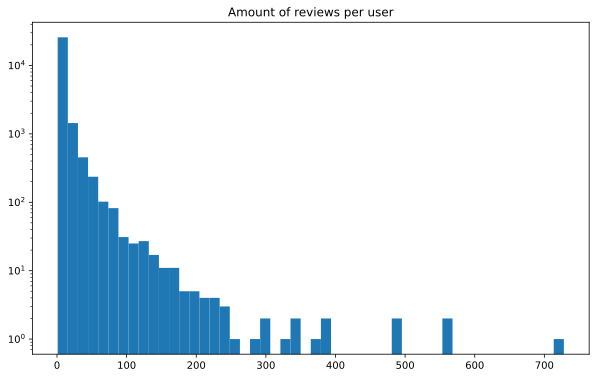

In [8]:
plt.hist(reviews.groupby("userid").size(), bins=50)
plt.yscale("log")
plt.title("Amount of reviews per user")
plt.show()

In [9]:
# Split for final evaluation
_train, _test, _holdout = timepoint_split(reviews, time_split_q=0.95)

len(_train), len(_test), len(_holdout)

(107153, 74000, 4421)

In [10]:
# Additional split for hyperparameter tuning
_trainval, _testval, _holdoutval = timepoint_split(_train, time_split_q=0.95)

len(_trainval), len(_testval), len(_holdoutval)

(76578, 23575, 2965)

In [11]:
def reindex_all(train, test, holdout=None, userid='userid', itemid='itemid'):
    train_new, data_index = transform_indices(train, userid, itemid)
    test_new = reindex_data(test, data_index, fields='items')
    
    if holdout is None:
        return train_new, test_new, data_index
    
    holdout_new = reindex_data(holdout, data_index, fields='items')
    return train_new, test_new, holdout_new, data_index


trainval, testval, holdoutval, data_index_val = reindex_all(_trainval, _testval, _holdoutval)

## Popular

In [12]:
data_description = {
    "n_users": trainval.userid.nunique(),
    "n_items": trainval.itemid.nunique(),
    "feedback": "rating",
    "items": "itemid",
    "users": "userid",
}

In [13]:
topn = 20

In [14]:
alphas = [2 ** p for p in range(15)]

popular_results = []

for a in alphas:
    def damped_mean(ratings):
        return sum(ratings) / (len(ratings) + a)
    
    item2rating = trainval.groupby('itemid')["rating"].apply(damped_mean)
    best_items = item2rating.nlargest(topn).index.values
    popular_recs = np.ones((len(holdoutval), topn)) * best_items
    metric = model_evaluate(popular_recs, holdoutval, data_description, topn)    
    
    popular_results.append({
        "alpha": a, "metric": metric
    })

popular_results = pd.DataFrame(popular_results)

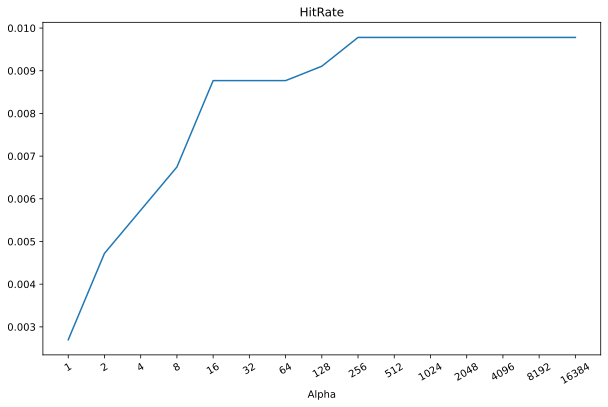

In [15]:
plt.plot(popular_results["alpha"], popular_results["metric"])
plt.xscale("log")
plt.xticks(popular_results["alpha"], popular_results["alpha"], rotation=30)
plt.tick_params(which="minor", size=0)
plt.title("HitRate")
plt.xlabel("Alpha")

plt.show()

In [16]:
popular_results = popular_results.sort_values("metric", ascending=False)

popular_results.head()

,alpha,metric
8,256,0.009781
9,512,0.009781
10,1024,0.009781
11,2048,0.009781
12,4096,0.009781


## Pure SVD

In [17]:
data_description = {
    "n_users": trainval.userid.nunique(),
    "n_items": trainval.itemid.nunique(),
    "feedback": "rating",
    "items": "itemid",
    "users": "userid",
}

In [18]:
ranks = [b * 2 ** p for p in range(0, 9) for b in [2, 3]]
ranks

[2, 3, 4, 6, 8, 12, 16, 24, 32, 48, 64, 96, 128, 192, 256, 384, 512, 768]

In [19]:
%%time
pure_svd_results = svd_gridsearch(ranks, trainval, testval, holdoutval, data_description, topn=20)

Interaction matrix shape: (19038, 5548)
Matrix density: 0.0006782151554667767
CPU times: user 1min 4s, sys: 3.99 s, total: 1min 8s
Wall time: 23.5 s


In [20]:
pure_svd_results = pd.DataFrame(pure_svd_results)

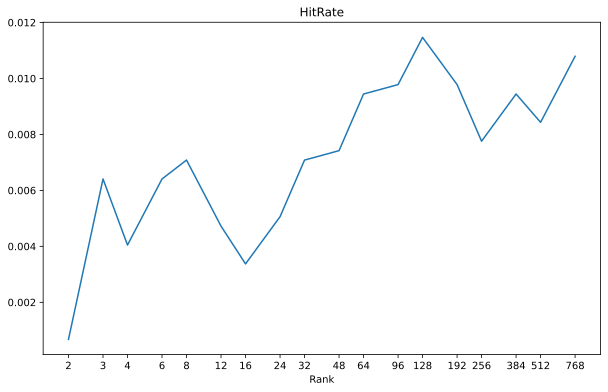

In [21]:
plt.plot(pure_svd_results["rank"], pure_svd_results["metric"])
plt.xscale("log")
plt.xticks(pure_svd_results["rank"], pure_svd_results["rank"])
plt.tick_params(which="minor", size=0)
plt.title("HitRate")
plt.xlabel("Rank")

plt.show()

In [22]:
pure_svd_results = pure_svd_results.sort_values("metric", ascending=False)

pure_svd_results.head()

,rank,metric
12,128,0.011467
17,768,0.010793
13,192,0.009781
11,96,0.009781
10,64,0.009444


## Scaled SVD

In [23]:
from scaled_svd import build_scaled_svd_model, scaled_svd_gridsearch

In [24]:
ranks = [b * 2 ** p for p in range(0, 9) for b in [2, 3]]
ranks

[2, 3, 4, 6, 8, 12, 16, 24, 32, 48, 64, 96, 128, 192, 256, 384, 512, 768]

In [25]:
scalings = np.arange(1, 10, 2) / 10
scalings

array([0.1, 0.3, 0.5, 0.7, 0.9])

In [26]:
%%time
scaled_svd_results = scaled_svd_gridsearch(ranks, scalings, trainval, testval, holdoutval, data_description, topn)

Scaling 0.1
Scaling 0.3
Scaling 0.5
Scaling 0.7
Scaling 0.9
CPU times: user 13min 50s, sys: 29.6 s, total: 14min 20s
Wall time: 4min 49s


In [27]:
scaled_svd_results = pd.DataFrame(scaled_svd_results)

scaled_svd_results = scaled_svd_results.sort_values("metric", ascending=False)

scaled_svd_results.head()

,rank,scaling,metric
48,128,0.5,0.011804
71,768,0.7,0.011804
89,768,0.9,0.011467
53,768,0.5,0.011130
17,768,0.1,0.011130


## SeqSVD

In [28]:
from seq_svd import full_seq_svd_gridsearch, build_seq_svd_model

In [29]:
ranks = [b * 2 ** p for p in range(0, 7) for b in [2, 3]]
ranks

[2, 3, 4, 6, 8, 12, 16, 24, 32, 48, 64, 96, 128, 192]

In [30]:
coefs = [0.25, 0.5]
thresholds = [0.003, 0.03] 
powers = [1, 0.8]
sim_types = ["cosine"]
scalings = np.arange(0.5, 4.5) / 10
scalings

array([0.05, 0.15, 0.25, 0.35])

In [31]:
%%time
seq_svd_results = full_seq_svd_gridsearch(ranks, coefs, powers, thresholds, sim_types, scalings,
                                          trainval, testval, holdoutval, data_description, topn)

Sequence similarity coef: 0.25, power: 1, threshold: 0.003, similarity type: cosine, scaling: 0.05
Sequence similarity coef: 0.25, power: 1, threshold: 0.003, similarity type: cosine, scaling: 0.15
Sequence similarity coef: 0.25, power: 1, threshold: 0.003, similarity type: cosine, scaling: 0.25
Sequence similarity coef: 0.25, power: 1, threshold: 0.003, similarity type: cosine, scaling: 0.35
Sequence similarity coef: 0.25, power: 1, threshold: 0.03, similarity type: cosine, scaling: 0.05
Sequence similarity coef: 0.25, power: 1, threshold: 0.03, similarity type: cosine, scaling: 0.15
Sequence similarity coef: 0.25, power: 1, threshold: 0.03, similarity type: cosine, scaling: 0.25
Sequence similarity coef: 0.25, power: 1, threshold: 0.03, similarity type: cosine, scaling: 0.35
Sequence similarity coef: 0.25, power: 0.8, threshold: 0.003, similarity type: cosine, scaling: 0.05
Sequence similarity coef: 0.25, power: 0.8, threshold: 0.003, similarity type: cosine, scaling: 0.15
Sequence s

In [32]:
seq_svd_results = pd.DataFrame(seq_svd_results)

seq_svd_results = seq_svd_results.sort_values("metric", ascending=False)

In [33]:
seq_svd_results.to_csv("tuning_results/second_seq_svd_tuning_amazon_grocery.csv")

## UserKNN

In [34]:
data_description = {
    "n_users": trainval.userid.nunique(),
    "n_items": trainval.itemid.nunique(),
    "feedback": "rating",
    "weights": "weights",
    "items": "itemid",
    "users": "userid",
}

trainval, testval = generate_ranks(trainval, data_description), generate_ranks(testval, data_description)

In [35]:
k_vals = [10, 25, 50, 100, 200, 250, 500, 1000, None]
p_vals = [0] # np.linspace(0, 1, 21)

config = {
    "similarity_A": "cosine", 
    "similarity_T": None,
}

In [36]:
%%time
results = uknn_gridsearch(k_vals, p_vals, config, trainval, testval, holdoutval, data_description, topn)

CPU times: user 1.13 s, sys: 229 ms, total: 1.36 s
Wall time: 1.39 s


In [37]:
knn_results = pd.DataFrame(results)

In [38]:
knn_results.drop("power", axis=1).sort_values('metric', ascending=False).head()

,k,metric
3,100.0,0.018212
4,200.0,0.017875
5,250.0,0.017875
1,25.0,0.017538
2,50.0,0.017201


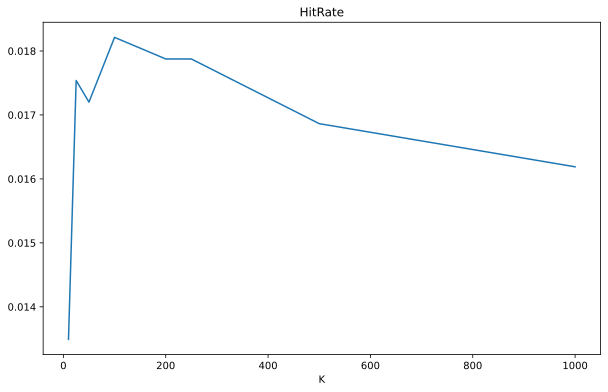

In [39]:
plt.plot(k_vals, knn_results.sort_values("k", na_position="last")["metric"])

plt.tick_params(which="minor", size=0)
plt.title("HitRate")
plt.xlabel("K")

plt.show()

## SeqUserKNN

In [40]:
%%time
k_vals = [10, 25, 50, 100, 200, 250, 500, 1000, None]
p_vals = np.linspace(0, 1, 21)

config = {
    "similarity_A": "cosine", 
    "similarity_T": "cosine",
}

results = uknn_gridsearch(k_vals, p_vals, config, trainval, testval, holdoutval, data_description, topn)

CPU times: user 23 s, sys: 5.21 s, total: 28.2 s
Wall time: 29.1 s


In [41]:
seq_knn_results = pd.DataFrame(results)
seq_knn_results.sort_values('metric', ascending=False).head()

,power,k,metric
62,0.3,NaN,0.021248
61,0.3,1000.0,0.021248
60,0.3,500.0,0.021248
58,0.3,200.0,0.021248
59,0.3,250.0,0.021248


In [42]:
seq_knn_results.pivot(index="power", columns="k", values="metric").style.format("{:.5f}").background_gradient(high=0.3, axis = None)


k,nan,10.000000,25.000000,50.000000,100.000000,200.000000,250.000000,500.000000,1000.000000
power,,,,,,,,,
0.000000,0.019899,0.01315,0.01855,0.01889,0.02024,0.02057,0.02024,0.01990,0.01990
0.050000,0.019562,0.01282,0.01821,0.01821,0.01990,0.02024,0.01990,0.01956,0.01956
0.100000,0.020236,0.01315,0.01889,0.01922,0.02024,0.02024,0.02024,0.02024,0.02024
0.150000,0.020236,0.01349,0.01855,0.01821,0.02024,0.01990,0.02024,0.02024,0.02024
0.200000,0.020573,0.01349,0.01889,0.01922,0.01990,0.02057,0.02057,0.02057,0.02057
0.250000,0.020573,0.01349,0.01889,0.01922,0.02024,0.02057,0.02057,0.02057,0.02057
0.300000,0.021248,0.01383,0.01922,0.01956,0.02091,0.02125,0.02125,0.02125,0.02125
0.350000,0.020236,0.01383,0.01720,0.01821,0.01990,0.02024,0.02057,0.02024,0.02024
0.400000,0.019562,0.01349,0.01720,0.01855,0.01990,0.01990,0.01990,0.01956,0.01956


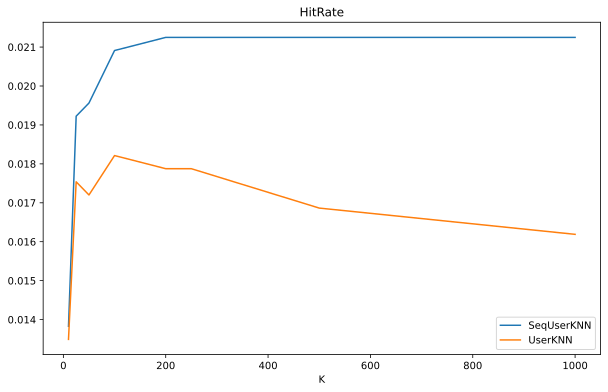

In [43]:
plt.plot(k_vals, seq_knn_results[lambda x: np.isclose(x["power"], 0.3)]["metric"], label="SeqUserKNN")
plt.plot(k_vals, knn_results["metric"], label="UserKNN")
plt.tick_params(which="minor", size=0)
plt.title("HitRate")
plt.xlabel("K")
plt.legend()

plt.show()

## Final Eval

In [44]:
train, test, holdout, data_index = reindex_all(_train, _test, _holdout)

In [45]:
data_description = {
    "n_users": train.userid.nunique(),
    "n_items": train.itemid.nunique(),
    "feedback": "rating",
    "weights": "weights",
    "items": "itemid",
    "users": "userid",
}

train = generate_ranks(train, data_description)
test = generate_ranks(test, data_description)

In [46]:
grand_total = []

In [47]:
idx = popular_results.idxmax()["metric"]
best_alpha = popular_results.loc[idx]["alpha"]
print(best_alpha)

def damped_mean(ratings):
    return sum(ratings) / (len(ratings) + best_alpha)

item2rating = train.groupby('itemid')["rating"].apply(damped_mean)
best_items = item2rating.nlargest(topn).index.values
popular_recs = np.ones((len(holdout), topn)) * best_items
metric = model_evaluate(popular_recs, holdout, data_description, topn)    

grand_total.append(
    {"method": "popularity", "metric": metric}
)

256.0


In [48]:
idx = pure_svd_results.idxmax()["metric"]
best_rank = pure_svd_results.loc[idx]["rank"]
print("Best rank:", best_rank)

model = build_svd_model({"rank": best_rank}, train, data_description)
scores = svd_scoring(model, test, data_description)
svd_recs = topn_recommendations(scores, topn)

metric = model_evaluate(svd_recs, holdout, data_description, topn)

grand_total.append(
    {"method": "PureSVD", "metric": metric}
)

Best rank: 128.0
Interaction matrix shape: (22920, 5604)
Matrix density: 0.000777585942726026


In [49]:
idx = scaled_svd_results.idxmax()["metric"]

best_config = {
    "rank": scaled_svd_results.loc[idx]["rank"], 
    "scaling": scaled_svd_results.loc[idx]["scaling"],
}
print(best_config)

model = build_scaled_svd_model(best_config, train, data_description)
scores = svd_scoring(model, test, data_description)
svd_recs = topn_recommendations(scores, topn)

metric = model_evaluate(svd_recs, holdout, data_description, topn)

grand_total.append(
    {"method": "ScaledSVD", "metric": metric}
)

{'rank': 128.0, 'scaling': 0.5}


In [50]:
idx = seq_svd_results["metric"].idxmax()

best_config = {
    "rank": seq_svd_results["rank"].loc[idx], 
    "sequence_similarity_coef": seq_svd_results["sequence_similarity_coef"].loc[idx],
    "similarity_type": seq_svd_results["similarity_type"].loc[idx],
    "incomplete_cholesky_threshold": seq_svd_results["incomplete_cholesky_threshold"].loc[idx],
    "scaling": seq_svd_results["scaling"].loc[idx],
    "power": seq_svd_results["power"].loc[idx],
}
print(best_config)

model = build_seq_svd_model(best_config, train, data_description)
scores = svd_scoring(model, test, data_description)
svd_recs = topn_recommendations(scores, topn)

metric = model_evaluate(svd_recs, holdout, data_description, topn)

grand_total.append(
    {"method": "SeqSVD", "metric": metric}
)

{'rank': 32, 'sequence_similarity_coef': 0.5, 'similarity_type': 'cosine', 'incomplete_cholesky_threshold': 0.03, 'scaling': 0.05, 'power': 0.8}


In [51]:
idx = knn_results["metric"].idxmax()

best_config = {
    "power": knn_results["power"].loc[idx],
    "k": knn_results["k"].loc[idx],
    "similarity_A": "cosine",
    "similarity_T": None
}

model = build_uknn_model(best_config, train, data_description)
scores = uknn_scoring(model, test, data_description)
uknn_recs = topn_recommendations(scores, topn)

metric = model_evaluate(uknn_recs, holdout, data_description, topn)

grand_total.append(
    {"method": "UserKNN", "metric": metric}
)

In [52]:
idx = seq_knn_results["metric"].idxmax()

best_config = {
    "power": seq_knn_results["power"].loc[idx],
    "k": seq_knn_results["k"].loc[idx],
    "similarity_A": "cosine",
    "similarity_T": "cosine"
}

model = build_uknn_model(best_config, train, data_description)
scores = uknn_scoring(model, test, data_description)
seq_uknn_recs = topn_recommendations(scores, topn)

metric = model_evaluate(seq_uknn_recs, holdout, data_description, topn)

grand_total.append(
    {"method": "SeqUserKNN", "metric": metric}
)

In [53]:
pd.DataFrame(grand_total).sort_values("metric", ascending=False)

,method,metric
5,SeqUserKNN,0.022619
4,UserKNN,0.019905
3,SeqSVD,0.011988
2,ScaledSVD,0.008143
1,PureSVD,0.007464
0,popularity,0.003845
